In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanAbsolutePercentageError as MAPE
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
import Dataset_Class as DC



# USE_CUDA = torch.cuda.is_available()
# DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE = 'cpu'
RANDOM_SEED = 2023

In [3]:
# pv 24h + 28 weather features(5 temp, 3 precip, 5 prob_precip, 5 humid, 5 wind speed, 5 sky)

pv_features = pd.read_csv('./processed_data/pv_forecastweather_feature.csv')
pv_features = pv_features.rename(columns={'Unnamed: 0':'date'}).set_index('date', drop=True)
pv_features_length = len(pv_features)

pv_features.index = [str(idx) for idx in pv_features.index]

# X: 52 features, Y: 24 features
X = pv_features.iloc[0:pv_features_length-1].copy(deep=True)
Y = pv_features.iloc[1:pv_features_length][['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']].copy(deep=True)  # X and Y should be divided completely, so Y get deeply copied.

In [4]:
X = torch.FloatTensor(X.values)
Y = torch.FloatTensor(Y.values)

In [5]:
dataset = DC.CustomDataset(X, Y)
data_len = dataset.__len__()

In [6]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)



# load forecast model에서 사용한 dataset 기간과 동일하게 설정
train_size = 186
mini_train_size = 148

train_data = DC.CustomDataset(X[:train_size], Y[:train_size])                                 # 186개   210104 ~ 211015
test_data = DC.CustomDataset(X[train_size:], Y[train_size:])                                  # 47개    211018 ~ 211229
mini_train_data = DC.CustomDataset(X[:mini_train_size], Y[:mini_train_size])                  # 148개   210104 ~ 210819
valid_data = DC.CustomDataset(X[mini_train_size:train_size], Y[mini_train_size:train_size])   # 38개    210820 ~ 211015

mini_train_dataloader = DataLoader(mini_train_data, batch_size = 32, shuffle = True)
valid_dataloader = DataLoader(valid_data, batch_size = valid_data.__len__(), shuffle = False)
train_dataloader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = test_data.__len__(), shuffle = False)

In [7]:
# same as model.ipynb
def train(model, trian_dataloader, optimizer, criterion):
    model.train()
    loss_sum = 0.0
    for (x, y) in train_dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        output = model(x)
        train_loss = criterion(output, y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        loss_sum += train_loss
    
    return (loss_sum/len(trian_dataloader.dataset)).item() # loss of each epoch


def evaluate(model, valid_dataloader):
    model.eval()
    with torch.no_grad():
        for (x, y) in valid_dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
                
            output = model(x)
            
        return output, y

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(52, 256)
        self.fc2 = nn.Linear(256, 1024)
        # self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(1024, 24)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.batch_norm2 = nn.BatchNorm1d(1024)
        # self.sig = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        # x = self.fc3(x)
        # x = self.relu(x)
        output = self.fc4(x)
        return output

In [9]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


model = Net().to(DEVICE)

EPOCHS = 40000
LEARNING_RATE = 0.0001
# MOMENTUM = 0.9

# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.MSELoss()
mini_train_loss_arr = []
val_loss_arr = []


# model training and validation
best_val_loss = float('inf')
best_val_epoch = 0


for epoch in range(EPOCHS):
    mini_train_loss = train(model, mini_train_dataloader, optimizer, criterion)
    mini_train_loss_arr.append(mini_train_loss)
    val_output, val_y = evaluate(model, valid_dataloader)
    val_loss = criterion(val_output, val_y)
    val_loss_arr.append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_epoch = epoch
        # torch.save(model.state_dict(), './model.pt')
        # print('state_dict format of the model:\n{}'.format(model.state_dict()))
    if epoch % 1000 == 0:
        print('Train Epoch: {:4d}/{}  |  Train Loss {:.6f}  |  Val Loss {:.6f}'.format(
            epoch, EPOCHS, mini_train_loss, val_loss))


print('-'*80)
print('The Best Epoch: {}  |  The Best Validation Error: {:.6f}'.format(
    best_val_epoch, best_val_loss
))

Train Epoch:    0/40000  |  Train Loss 2118.276855  |  Val Loss 36334.878906
Train Epoch: 1000/40000  |  Train Loss 151.821854  |  Val Loss 3322.465088
Train Epoch: 2000/40000  |  Train Loss 74.078148  |  Val Loss 1387.587158
Train Epoch: 3000/40000  |  Train Loss 33.223202  |  Val Loss 480.815735
Train Epoch: 4000/40000  |  Train Loss 32.814491  |  Val Loss 201.733780
Train Epoch: 5000/40000  |  Train Loss 17.206982  |  Val Loss 96.819389
Train Epoch: 6000/40000  |  Train Loss 23.032526  |  Val Loss 79.577209
Train Epoch: 7000/40000  |  Train Loss 11.584043  |  Val Loss 53.225269
Train Epoch: 8000/40000  |  Train Loss 12.617594  |  Val Loss 43.042305
Train Epoch: 9000/40000  |  Train Loss 9.176161  |  Val Loss 45.615688
Train Epoch: 10000/40000  |  Train Loss 10.431137  |  Val Loss 48.587379
Train Epoch: 11000/40000  |  Train Loss 11.929172  |  Val Loss 36.964642
Train Epoch: 12000/40000  |  Train Loss 15.361239  |  Val Loss 35.174030
Train Epoch: 13000/40000  |  Train Loss 10.202566 

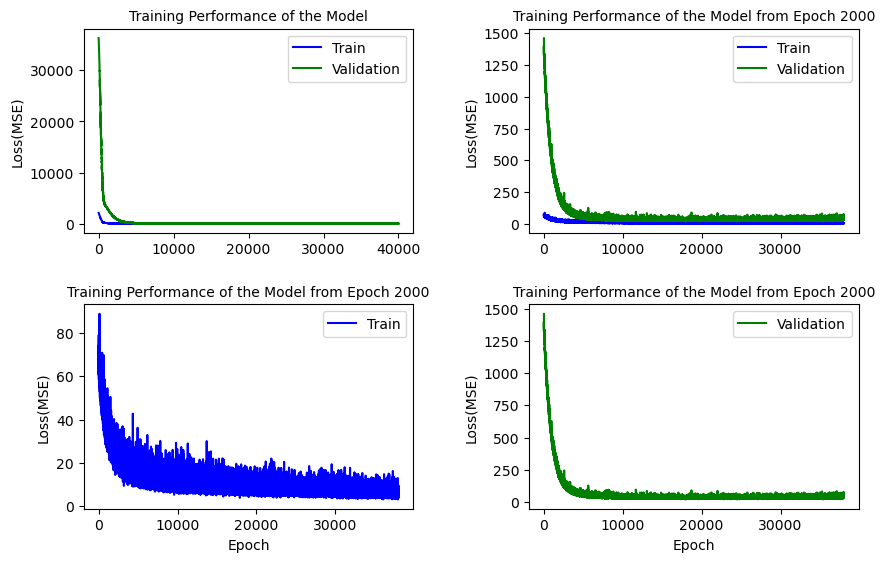

In [10]:
fig = plt.figure(figsize=(10,6))

FONT_SIZE = 10

plt.subplot(221)
plt.title('Training Performance of the Model', fontsize = FONT_SIZE)
# plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[0:], c = 'blue', label = 'Train')
plt.plot(val_loss_arr[0:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(222)
plt.title('Training Performance of the Model from Epoch 2000', fontsize = FONT_SIZE)
# plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[2000:], c = 'blue', label = 'Train')
plt.plot(val_loss_arr[2000:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(223)
plt.title('Training Performance of the Model from Epoch 2000', fontsize = FONT_SIZE)
plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(mini_train_loss_arr[2000:], c = 'blue', label = 'Train')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplot(224)
plt.title('Training Performance of the Model from Epoch 2000', fontsize = FONT_SIZE)
plt.xlabel('Epoch', fontsize = FONT_SIZE)
plt.ylabel('Loss(MSE)', fontsize = FONT_SIZE)
# plt.yscale('log')
plt.plot(val_loss_arr[2000:], c = 'green', label = 'Validation')
plt.legend(loc='upper right', fontsize = FONT_SIZE)

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)

In [11]:
torch.save(model.state_dict(), './model_pt/pv_frcst_wthr_model_1024_BN_40000.pt')

In [12]:
# fix the seed for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


mae = nn.L1Loss()
mape = MAPE()


for epoch in range(best_val_epoch):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    if epoch % 1000 == 0:
        print('Train Epoch: {:4d}/{}  |  Train Loss {:.6f}'.format(
            epoch, best_val_epoch, train_loss))

Train Epoch:    0/37368  |  Train Loss 2.887824
Train Epoch: 1000/37368  |  Train Loss 4.268919
Train Epoch: 2000/37368  |  Train Loss 5.321710
Train Epoch: 3000/37368  |  Train Loss 5.115903
Train Epoch: 4000/37368  |  Train Loss 2.685960
Train Epoch: 5000/37368  |  Train Loss 4.319065
Train Epoch: 6000/37368  |  Train Loss 3.396419
Train Epoch: 7000/37368  |  Train Loss 4.008469
Train Epoch: 8000/37368  |  Train Loss 4.307391
Train Epoch: 9000/37368  |  Train Loss 3.801752
Train Epoch: 10000/37368  |  Train Loss 5.215053
Train Epoch: 11000/37368  |  Train Loss 3.362660
Train Epoch: 12000/37368  |  Train Loss 2.702017
Train Epoch: 13000/37368  |  Train Loss 3.029658
Train Epoch: 14000/37368  |  Train Loss 2.458037
Train Epoch: 15000/37368  |  Train Loss 3.499950
Train Epoch: 16000/37368  |  Train Loss 3.169090
Train Epoch: 17000/37368  |  Train Loss 2.852632
Train Epoch: 18000/37368  |  Train Loss 2.589911
Train Epoch: 19000/37368  |  Train Loss 4.431198
Train Epoch: 20000/37368  |  T

In [17]:
torch.save(model.state_dict(), './model_pt/pv_frcst_wthr_model_1024_40000_BN_train.pt')

In [18]:
test_output, test_y = evaluate(model, test_dataloader)

# 6~20시에만 PV 발전량 존재. PV 발전량 음수는 안 나온다.
test_output = torch.where(test_output > 0, test_output, 0)  # 새롭게 추가된 코드!
test_output[:,0:6] = 0
test_output[:, 21:] = 0


test_mse = criterion(test_output, test_y)
test_mae = mae(test_output, test_y)
# test_mape = mape(test_output, test_y)


# TODO: MAPE 나타내보기.. 일부 값들만 선택해서!
print('Test Loss')
print('MSE: {:.6f}'.format(test_mse))
print('MAE: {:.6f}'.format(test_mae))
# print('MAPE(%): {:.6f}'.format(test_mape*100))  # 실제 정답값에 0이 포함되기 때문에 계산 불가능

Test Loss
MSE: 9897.200195
MAE: 50.500713


In [15]:
def plot(i, length, output, Y):
    fig = plt.figure(figsize=(20, 5))
    ax = plt.axes()
    plt.title('Actual and forecast PV generation for 20 days', fontsize = 18)
    plt.xlabel('Time (h)', fontsize = 15)
    plt.ylabel('Net-load', fontsize = 15)
    x_ticks = range(0,length*24, 24)
    x_labels = range(0, length)
    ax.set_xticks(x_ticks, x_labels)
    plt.plot(Y.detach().numpy()[i:i+(length*24),:].reshape(-1), c='blue', label = 'Actual data')
    plt.plot(output.detach().numpy()[i:i+(length*24),:].reshape(-1), c='red', label = 'forecast data')
    plt.legend(loc='lower right', fontsize = 13)


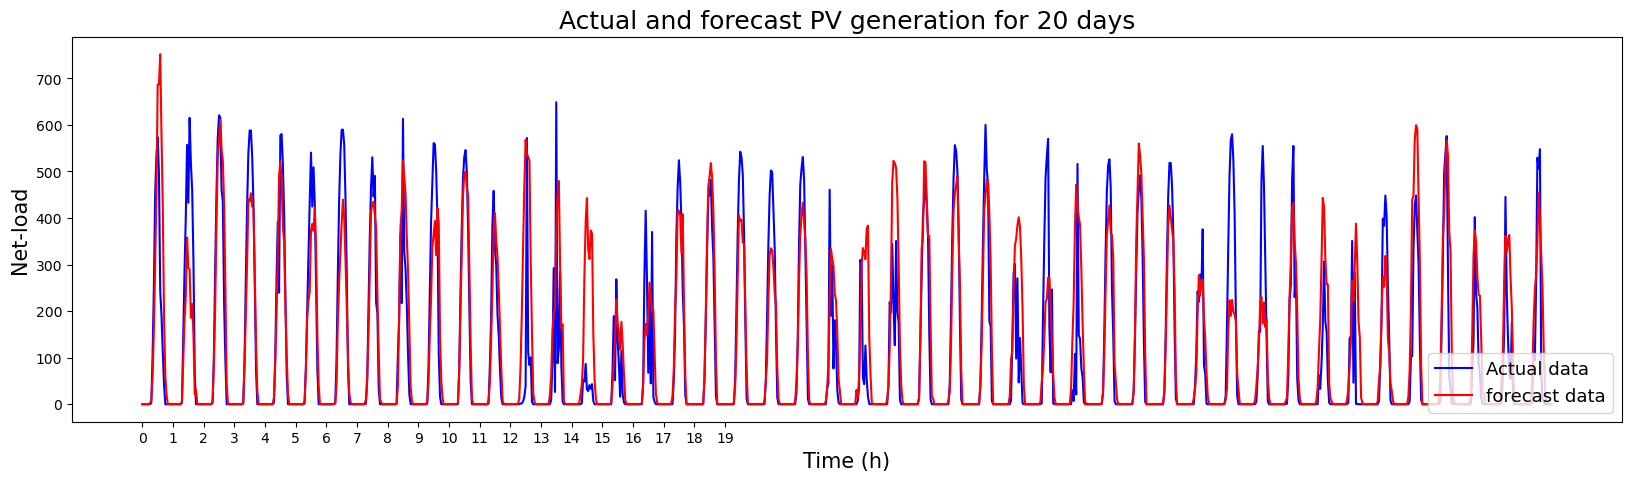

In [19]:
# 211020 ~ 211117
plot(1, 20, test_output, test_y)